# 15.RNN을 이용한 인코더-디코더

이번 챕터에서는 seq2seq 모델과 이를 위한 어텐션 메커니즘에 대해서 학습한다.



## 1) 시퀀스-투-시퀀스(Sequence-to-Sequence, seq2seq)

참고 : 이번 챕터의 실습은 케라스 함수형 API에 대한 이해가 필요하다. 8챕터(https://wikidocs.net/38861)를 참고하기 바란다.

시퀀스-투-시퀀스(Sequence-to-Sequence)는 입력된 시퀀스로부터 다른 도메인의 시퀀스를 출력하는 다양한 분야에서 사용되는 모델이다. 예를 들어 챗봇(Chatbot)과 기계 번역(Machine Translation)이 그러한 대표적인 예시인데, 입력 시퀀스와 출력 시퀀스를 각각 입력 문장과 번역 문장으로 만들면 번역기를 만들 수 있다. 그 외에도 내용 요약(Text Summarization), STT(Speech to Text) 등에서 쓰일 수 있다.

이번 챕터에서는 기계 번역을 예제로 시퀀스-투-시퀀스를 설명한다. 앞으로는 줄여서 seq2seq이라는 이름으로 설명하겠다. seq2seq에 대한 구조를 이해하고, 케라스(Keras)를 통해 직접 구현해보자.


### 1.시퀀스-투-시퀀스(Sequence-to-Sequence)

seq2seq는 번역기에서 대표적으로 사용되는 모델이다. 앞으로의 설명 방식은 내부가 보이지 않는 커다란 블랙 박스에서 점차적으로 확대해가는 방식으로 설명한다. 참고로 여기서 설명하는 내용의 대부분은 RNN 챕터에서 언급한 내용들이다. 단지 이것을 가지고 어떻게 조립했느냐에 따라서 seq2seq라는 구조가 만들어진다.

<img src = 'https://wikidocs.net/images/page/24996/%EC%8B%9C%ED%80%80%EC%8A%A4%ED%88%AC%EC%8B%9C%ED%80%80%EC%8A%A4.PNG' width = 60%>

위의 그림은 seq2seq 모델로 만들어진 번역기가 'I am a student'라는 영어 문장을 입력받아서, 'je suis étudiant'라는 프랑스어 문장을 출력하는 모습을 보여준다. 그렇다면, seq2seq 모델 내부의 모습은 어떻게 구성되었을까?

<img src = 'https://wikidocs.net/images/page/24996/seq2seq%EB%AA%A8%EB%8D%B811.PNG' width = 60%>

seq2seq는 크게 두 개로 구성된 아키텍처로 구성되는데, 바로 인코더와 디코더이다. 인코더는 입력 문장의 모든 단어들을 순차적으로 입력받은 뒤에 마지막에 이 모든 단어 정보들을 압축해서 하나의 벡터로 만드는데, 이를 컨텍스트 벡터(context vector)라고 한다. 입력 문장의 정보가 하나의 컨텍스트 벡터로 모두 압축되면 인코더는 컨텍스트 벡터를 디코더로 전송한다. 디코더는 컨텍스트 벡터를 받아서 번역된 단어를 한 개씩 순차적으로 출력한다.

<img src = 'https://wikidocs.net/images/page/24996/%EC%BB%A8%ED%85%8D%EC%8A%A4%ED%8A%B8_%EB%B2%A1%ED%84%B0.PNG' width = 60%>

컨텍스트 벡터에 대해서는 뒤에서 다시 언급하겠다. 위의 그림에서는 컨텍스트 벡터를 4의 사이즈로 표현하였지만, 실제 현업에서 사용되는 seq2seq 모델에서는 보통 수백 이상의 차원을 갖고 있다. 이제 인코더와 디코더의 내부를 좀 더 확대해보겠다.

<img src = 'https://wikidocs.net/images/page/24996/%EC%9D%B8%EC%BD%94%EB%8D%94%EB%94%94%EC%BD%94%EB%8D%94%EB%AA%A8%EB%8D%B8.PNG' width = 60%>

인코더 아키텍처와 디코더 아키텍처의 내부는 사실 두 개의 RNN 아키텍처이다. 입력 문장을 받는 RNN 셀을 인코더라고 하고, 출력 문장을 출력하는 RNN 셀을 디코더라고 한다. 이번 챕터에서는 인코더의 RNN 셀을 주황색으로, 디코더의 RNN 셀을 초록색으로 표현한다. 물론, 성능 문제로 인해 실제로는 바닐라 RNN이 아니라 **LSTM 셀** 또는 **GRU 셀**들로 구성된다. 우선 인코더를 자세히 보면, 입력 문장은 단어 토큰화를 통해서 단어 단위로 쪼개지고 단어 토큰 각각은 RNN 셀의 각 시점의 입력이 된다. 인코더 RNN 셀은 모든 단어를 입력받은 뒤에 **인코더 RNN 셀의 마지막 시점의 은닉 상태**를 디코더 RNN 셀로 넘겨주는데 이를 **컨텍스트 벡터**라고 한다. 컨텍스트 벡터는 **디코더 RNN 셀의 첫번째 은닉 상태**로 사용된다.

디코더는 기본적으로 RNNLM(RNN Language Model)이다. 그래서 RNNLM의 개념을 기억하고 있다면 좀 더 이해하기 쉽지만, 기억하지 못 하더라도 다시 처음부터 설명할 것이므로 상관없다.

디코더는 초기 입력으로 문장의 시작을 의미하는 심볼 <(sos)>가 들어간다. 디코더는 <(sos)>가 입력되면, 다음에 등장할 확률이 높은 단어를 예측한다. 첫번째 시점(time step)의 디코더 RNN 셀은 다음에 등장할 단어로 je를 예측하였다. 첫번째 시점의 디코더 RNN 셀은 예측된 단어 je를 다음 시점의 RNN 셀의 입력으로 입력한다. 그리고 두번째 시점의 디코더 RNN 셀은 입력된 단어 je로부터 다시 다음에 올 단어인 suis를 예측하고, 또 다시 이것을 다음 시점의 RNN 셀의 입력으로 보낸다. 디코더는 이런 식으로 기본적으로 다음에 올 단어를 예측하고, 그 예측한 단어를 다음 시점의 RNN 셀의 입력으로 넣는 행위를 반복한다. 이 행위는 문장의 끝을 의미하는 심볼인 <(eos)>가 다음 단어로 예측될 때까지 반복된다. **지금 설명하는 것은 테스트 과정** 동안의 이야기이다.

seq2seq는 훈련 과정과 테스트 과정(또는 실제 번역기를 사람이 쓸 때)의 작동 방식이 조금 다르다. 훈련 과정에서는 디코더에게 인코더가 보낸 컨텍스트 벡터와 실제 정답인 상황인 <(sos)> je suis étudiant를 입력 받았을 때, je suis étudiant <(eos)>가 나와야 된다고 정답을 알려주면서 훈련한다. 이에 대해서는 뒤에 **교사 강요(teacher forcing)**를 설명하면서 다시 언급하겠다. 반면 테스트 과정에서는 앞서 설명한 과정과 같이 디코더는 오직 컨텍스트 벡터와 <(sos)>만을 입력으로 받은 후에 다음에 올 단어를 예측하고, 그 단어를 다음 시점의 RNN 셀의 입력으로 넣는 행위를 반복한다. 즉, 앞서 설명한 과정과 위의 그림은 테스트 과정에 해당된다. 이번에는 입, 출력에 쓰이는 단어 토큰들이 있는 부분을 좀 더 확대해보겠다.

<img src = 'https://wikidocs.net/images/page/24996/%EB%8B%A8%EC%96%B4%ED%86%A0%ED%81%B0%EB%93%A4%EC%9D%B4.PNG' width = 60%>

기계는 텍스트보다 숫자를 잘 처리한다. 그리고 자연어 처리에서 텍스트를 벡터로 바꾸는 방법으로 워드 임베딩(10챕터 참고)이 사용된다고 설명한 바 있다. 즉, seq2seq에서 사용되는 모든 단어들은 워드 임베딩을 통해 임베딩 벡터로서 표현된 임베딩 벡터이다. 위 그림은 모든 단어에 대해서 임베딩 과정을 거치게 하는 단계인 임베딩 층(embedding layer)의 모습을 보여준다.

<img src = 'https://wikidocs.net/images/page/24996/%EC%9E%84%EB%B2%A0%EB%94%A9%EB%B2%A1%ED%84%B0.PNG' width = 60%>

예를 들어 I, am, a, student라는 단어들에 대한 임베딩 벡터는 위와 같은 모습을 가진다. 여기서는 그림으로 표현하고자 사이즈를 4로 하였지만, 보통 실제 임베딩 벡터는 수백 개의 차원을 가질 수 있다. 이제 RNN 셀에 대해서 확대해보겠다.

이미 RNN에 대해서 배운 적이 있지만, 다시 복습을 해보도록 하겠다. 하나의 RNN 셀은 각각의 시점(time step)마다 두 개의 입력을 받는다. (이해가 되지 않는다면, RNN 챕터를 다시 참고하라.)

<img src = 'https://wikidocs.net/images/page/24996/rnn%EA%B7%BC%ED%99%A9.PNG' width = 60%>

현재 시점(time step)을 t라고 할 때, RNN 셀은 t-1에서의 은닉 상태와 t에서의 입력 벡터를 입력으로 받고, t에서의 은닉 상태를 만든다. 이때 t에서의 은닉 상태는 바로 위에 또 다른 은닉층이나 출력층이 존재할 경우에는 위의 층으로 보내거나, 필요없으면 값을 무시할 수 있다. 그리고 RNN 셀은 다음 시점에 해당하는 t+1의 RNN 셀의 입력으로 현재 t에서의 은닉 상태를 입력으로 보낸다.

RNN 챕터에서도 언급했지만, 이런 구조에서 현재 시점 t에서의 은닉 상태는 과거 시점의 동일한 RNN 셀에서의 모든 은닉 상태의 값들의 영향을 누적해서 받아온 값이라고 할 수 있다. 그렇기 때문에 앞서 우리가 언급했던 컨텍스트 벡터는 사실 인코더에서의 마지막 RNN 셀의 은닉 상태값을 말하는 것이며, 이는 입력 문장의 모든 단어 토큰들의 정보를 요약해서 담고 있다고 할 수 있다.

디코더는 인코더의 마지막 RNN 셀의 은닉 상태인 컨텍스트 벡터를 첫번째 은닉 상태의 값으로 사용한다. 디코더의 첫번째 RNN 셀은 이 첫번째 은닉 상태의 값과, 현재 t에서의 입력값인 <(sos)>로부터, 다음에 등장할 단어를 예측한다. 그리고 이 예측된 단어는 다음 시점인 t+1 RNN에서의 입력값이 되고, 이 t+1에서의 RNN 또한 이 입력값과 t에서의 은닉 상태로부터 t+1에서의 출력 벡터. 즉, 또 다시 다음에 등장할 단어를 예측하게 될 것이다. 이제 디코더가 다음에 등장할 단어를 예측하는 부분을 확대해보도록 하겠다.

<img src = 'https://wikidocs.net/images/page/24996/decodernextwordprediction.PNG' width = 60%>

출력 단어로 나올 수 있는 단어들은 다양한 단어들이 있다. seq2seq 모델은 선택될 수 있는 모든 단어들로부터 하나의 단어를 골라서 예측해야 한다. 이를 예측하기 위해서 쓸 수 있는 함수로는 뭐가 있을까? 바로 소프트맥스 함수이다. 디코더에서 각 시점(time step)의 RNN 셀에서 출력 벡터가 나오면, 해당 벡터는 소프트맥스 함수를 통해 출력 시퀀스의 각 단어별 확률값을 반환하고, 디코더는 출력 단어를 결정한다.

지금까지 가장 기본적인 seq2seq에 대해서 배워보았다. 사실 seq2seq는 어떻게 구현하느냐에 따라서 충분히 더 복잡해질 수 있다. 컨텍스트 벡터를 디코더의 초기 은닉 상태로만 사용할 수도 있고, 거기서 더 나아가 컨텍스트 벡터를 디코더가 단어를 예측하는 매 시점마다 하나의 입력으로 사용할 수도 있으며 거기서 더 나아가면 어텐션 메커니즘이라는 방법을 통해 지금 알고 있는 컨텍스트 벡터보다 더욱 문맥을 반영할 수 있는 컨텍스트 벡터를 구하여 매 시점마다 하나의 입력으로 사용할 수도 있다. 어텐션 메커니즘에 대해서는 다음 챕터에서 배운다.



### 2.글자 레벨 기계 번역기(Character-Level Neural Machine Translation) 구현하기

이제 seq2seq를 이용해서 기계 번역기를 만들어보도록 하겠다. 시작하기에 앞서 참고하면 좋은 게시물을 소개한다. 인터넷에 케라스로 seq2seq를 구현하는 많은 유사 예제들이 나와있지만 대부분은 케라스 개발자 프랑수아 숄레의 블로그의 유명 게시물인 'sequence-to-sequence 10분만에 이해하기'가 원본이다. 이번 실습 또한 해당 게시물의 예제에 많이 영향을 받았다.

해당 게시물 링크 : https://blog.keras.io/a-ten-minute-introduction-to-sequence-to-sequence-learning-in-keras.html

실제 성능이 좋은 기계 번역기를 구현하려면 정말 방대한 데이터가 필요하므로 여기서는 방금 배운 seq2seq를 실습해보는 수준에서 아주 간단한 기계 번역기를 구축해보도록 하겠다. 기계 번역기를 훈련시키기 위해서는 훈련 데이터로 병렬 코퍼스(parallel corpus)가 필요하다. 병렬 코퍼스란, 두 개 이상의 언어가 병렬적으로 구성된 코퍼스를 의미한다.

다운로드 링크 : http://www.manythings.org/anki

이번 실습에서는 프랑스-영어 병렬 코퍼스인 fra-eng.zip 파일을 사용할 것이다. 위의 링크에서 해당 파일을 다운받으면 된다. 해당 파일의 압축을 풀면 fra.txt라는 파일이 있는데 이 파일이 이번 실습에서 사용할 파일이다.



In [1]:
# Google Drive Mount
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
cd /content/drive/MyDrive/데이터

/content/drive/MyDrive/데이터


In [3]:
ls

 _about.txt            fra-eng.zip                        model.png
'강우예측AI 데이터'/   fra.txt                            ratings.txt
 eng_w2v               IWSLT16.TED.tst2011.en-cs.en.xml   wikiextractor/


#### 1) 병렬 코퍼스 데이터에 대한 이해와 전처리

우선 병렬 코퍼스 데이터에 대한 이해를 해보겠다. 병렬 데이터라고 하면 앞서 수행한 태깅 작업의 데이터를 생각할 수 있지만, 앞서 수행한 태깅 작업의 병렬 데이터와 seq2seq가 사용하는 병렬 데이터는 성격이 조금 다르다. 태깅 작업의 병렬 데이터는 쌍이 되는 모든 데이터가 길이가 같았지만 여기서는 쌍이 된다고 해서 길이가 같지 않다.

실제 번역기를 생각해보면 구글 번역기에 '나는 학생이다.'라는 토큰의 개수가 2인 문장을 넣었을 때 'I am a student.'라는 토큰의 개수가 4인 문장이 나오는 것과 같은 이치이다. seq2seq는 기본적으로 입력 시퀀스와 출력 시퀀스의 길이가 다를 수 있다고 가정한다. 지금은 기계 번역기가 예제지만 seq2seq의 또 다른 유명한 예제 중 하나인 챗봇을 만든다고 가정해보면, 대답의 길이가 질문의 길이와 항상 똑같아야 한다고 하면 그 또한 이상하다.

Watch me.           Regardez-moi !

여기서 사용할 fra.txt 데이터는 위와 같이 왼쪽의 영어 문장과 오른쪽의 프랑스어 문장 사이에 탭으로 구분되는 구조가 하나의 샘플이다. 그리고 이와 같은 형식의 약 16만개의 병렬 문장 샘플을 포함하고 있다. 해당 데이터를 읽고 전처리를 진행해보겠다. 앞으로의 코드에서 src는 source의 줄임말로 입력 문장을 나타내며, tar는 target의 줄임말로 번역하고자 하는 문장을 나타낸다.


In [4]:
import pandas as pd
import urllib3
import zipfile
import shutil
import os
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

In [5]:
http = urllib3.PoolManager()
url ='http://www.manythings.org/anki/fra-eng.zip'
filename = 'fra-eng.zip'
path = os.getcwd()
zipfilename = os.path.join(path, filename)
with http.request('GET', url, preload_content=False) as r, open(zipfilename, 'wb') as out_file:       
    shutil.copyfileobj(r, out_file)

with zipfile.ZipFile(zipfilename, 'r') as zip_ref:
    zip_ref.extractall(path)

In [6]:
lines = pd.read_csv('fra.txt', names=['src', 'tar', 'lic'], sep='\t')
del lines['lic']
len(lines)

179904

전체 샘플의 개수는 총 약 17만 9천개이다.

In [7]:
lines = lines.loc[:, 'src':'tar']
lines = lines[0:60000] # 6만개만 저장
lines.sample(10)

,src,tar
34776,You've gone too far.,Tu es allée trop loin.
40675,Why does this matter?,Pourquoi est-ce important ?
36082,How can you say that?,Comment pouvez-vous dire cela ?
15282,I caught the flu.,J'ai chopé la grippe.
46484,Tom's answer is wrong.,La réponse de Tom est fausse.
38129,It's an unusual name.,C'est un nom peu commun.
15085,Here is your key.,Voici votre clé.
23906,Call me right back.,Rappelez-moi de suite !
3099,Tom'll come.,Tom viendra.
59539,This trip was your idea.,Ce voyage était votre idée.


해당 데이터는 약 17만 9천개의 병렬 문장 샘플로 구성되어 있지만 여기서는 간단히 60,000개의 샘플만 가지고 기계 번역기를 구축해보도록 하겠다. 우선 전체 데이터 중 60,000개의 샘플만 저장하고 현재 데이터가 어떤 구성이 되었는지 확인해보겠다.

위의 테이블은 랜덤으로 선택된 10개의 샘플을 보여준다. 번역 문장에 해당되는 프랑스어 데이터는 앞서 배웠듯이 시작을 의미하는 심볼 <(sos)>와 종료를 의미하는 심볼 <(eos)>를 넣어주어야 한다. 여기서는 <(sos)>와 <(eos)> 대신 '\t'를 시작 심볼, '\n'을 종료 심볼로 간주하여 추가하고 다시 데이터를 출력해보겠다.


In [8]:
lines.tar = lines.tar.apply(lambda x: '\t' + x + '\n')
lines.sample(10)

,src,tar
58432,Please sum up your idea.,\tVeuillez résumer votre idée.\n
3804,I feel faint.,\tJe sens que je vais m'évanouir.\n
57052,I think Tom is impolite.,\tJe pense que Tom est impoli.\n
9552,Take that back.,\tRetirez ça !\n
178,I tried.,\tJ'essayai.\n
14840,He can read well.,\tIl sait bien lire.\n
15184,I almost drowned.,\tJe me suis presque noyée.\n
11517,I have dandruff.,\tJ'ai des pellicules.\n
9163,It's not right.,\tCe n'est pas correct.\n
12691,No one did that.,\tPersonne ne l'a fait.\n


랜덤으로 10개의 샘플을 선택하여 출력하였다. 프랑스어 데이터에서 시작 심볼과 종료 심볼이 추가된 것을 볼 수 있다. 이제 글자 집합을 생성해보겠다. 단어 집합이 아니라 글자 집합이라고 하는 이유는 토큰 단위가 단어가 아니라 글자이기 때문이다.


In [9]:
# 글자 집합 구축
src_vocab = set()
for line in lines.src: # 1줄씩 읽음
    for char in line: # 1개의 글자씩 읽음
        src_vocab.add(char)

tar_vocab = set()
for line in lines.tar:
    for char in line:
        tar_vocab.add(char)

글자 집합의 크기를 보겠다.

In [10]:
src_vocab_size = len(src_vocab) + 1
tar_vocab_size = len(tar_vocab) + 1
print(src_vocab_size)
print(tar_vocab_size)

79
106


영어와 프랑스어는 각각 약 80개와 100개의 글자가 존재한다. 이 중에서 인덱스를 임의로 부여하여 일부만 출력해보자. 현 상태에서 인덱스를 사용하려고 하면 에러가 난다. 하지만 정렬하여 순서를 정해준 뒤에 인덱스를 사용하여 출력해주면 된다.


In [11]:
src_vocab = sorted(list(src_vocab))
tar_vocab = sorted(list(tar_vocab))
print(src_vocab[45:75])
print(tar_vocab[45:75])

['W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
['T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w']


글자 집합에 글자 단위로 저장된 것을 확인할 수 있다. 이제 각 글자에 인덱스를 부여하겠다.


In [12]:
src_to_index = dict([(word, i + 1) for i, word in enumerate(src_vocab)])
tar_to_index = dict([(word, i + 1) for i, word in enumerate(tar_vocab)])
print(src_to_index)
print(tar_to_index)

{' ': 1, '!': 2, '"': 3, '$': 4, '%': 5, '&': 6, "'": 7, ',': 8, '-': 9, '.': 10, '/': 11, '0': 12, '1': 13, '2': 14, '3': 15, '4': 16, '5': 17, '6': 18, '7': 19, '8': 20, '9': 21, ':': 22, '?': 23, 'A': 24, 'B': 25, 'C': 26, 'D': 27, 'E': 28, 'F': 29, 'G': 30, 'H': 31, 'I': 32, 'J': 33, 'K': 34, 'L': 35, 'M': 36, 'N': 37, 'O': 38, 'P': 39, 'Q': 40, 'R': 41, 'S': 42, 'T': 43, 'U': 44, 'V': 45, 'W': 46, 'X': 47, 'Y': 48, 'Z': 49, 'a': 50, 'b': 51, 'c': 52, 'd': 53, 'e': 54, 'f': 55, 'g': 56, 'h': 57, 'i': 58, 'j': 59, 'k': 60, 'l': 61, 'm': 62, 'n': 63, 'o': 64, 'p': 65, 'q': 66, 'r': 67, 's': 68, 't': 69, 'u': 70, 'v': 71, 'w': 72, 'x': 73, 'y': 74, 'z': 75, 'é': 76, '’': 77, '€': 78}
{'\t': 1, '\n': 2, ' ': 3, '!': 4, '"': 5, '$': 6, '%': 7, '&': 8, "'": 9, '(': 10, ')': 11, ',': 12, '-': 13, '.': 14, '0': 15, '1': 16, '2': 17, '3': 18, '4': 19, '5': 20, '6': 21, '7': 22, '8': 23, '9': 24, ':': 25, '?': 26, 'A': 27, 'B': 28, 'C': 29, 'D': 30, 'E': 31, 'F': 32, 'G': 33, 'H': 34, 'I': 3

이제 인덱스가 부여된 글자 집합으로부터 갖고 있는 훈련 데이터에 정수 인코딩을 수행하겠다. 우선 인코더의 입력이 될 영어 문장 샘플에 대해서 정수 인코딩을 수행해보고, 5개의 샘플을 출력해보자.


In [13]:
encoder_input = []
for line in lines.src: #입력 데이터에서 1줄씩 문장을 읽음
    temp_X = []
    for w in line: #각 줄에서 1개씩 글자를 읽음
      temp_X.append(src_to_index[w]) # 글자를 해당되는 정수로 변환
    encoder_input.append(temp_X)
print(encoder_input[:5])

[[30, 64, 10], [31, 58, 10], [31, 58, 10], [41, 70, 63, 2], [41, 70, 63, 2]]


정수 인코딩이 수행된 것을 볼 수 있다. 이제 디코더의 입력이 될 프랑스어 데이터에 대해서 정수 인코딩을 수행해보겠다.


In [14]:
decoder_input = []
for line in lines.tar:
    temp_X = []
    for w in line:
        temp_X.append(tar_to_index[w])
    decoder_input.append(temp_X)
print(decoder_input[:5])

[[1, 48, 53, 3, 4, 2], [1, 45, 53, 64, 73, 72, 3, 4, 2], [1, 45, 53, 64, 73, 72, 14, 2], [1, 29, 67, 73, 70, 71, 105, 4, 2], [1, 29, 67, 73, 70, 57, 78, 105, 4, 2]]


정상적으로 정수 인코딩이 수행된 것을 볼 수 있다. 아직 정수 인코딩을 수행해야 할 데이터가 하나 더 남았다. 디코더의 예측값과 비교하기 위한 실제값이 필요하다. 그런데 이 실제값에는 시작 심볼에 해당되는 <(sos)>가 있을 필요가 없다. 이해가 되지 않는다면 이전 페이지의 그림으로 돌아가 Dense와 Softmax 위에 있는 단어들을 다시 보기 바란다. 그래서 이번에는 정수 인코딩 과정에서 <(sos)>를 제거한다. 즉, 모든 프랑스어 문장의 맨 앞에 붙어있는 '\t'를 제거하도록 한다.


In [15]:
decoder_target = []
for line in lines.tar:
    t = 0
    temp_X = []
    for w in line:
        if t > 0:
            temp_X.append(tar_to_index[w])
        t = t + 1
    decoder_target.append(temp_X)
print(decoder_target[:5])

[[48, 53, 3, 4, 2], [45, 53, 64, 73, 72, 3, 4, 2], [45, 53, 64, 73, 72, 14, 2], [29, 67, 73, 70, 71, 105, 4, 2], [29, 67, 73, 70, 57, 78, 105, 4, 2]]


앞서 먼저 만들었던 디코더의 입력값에 해당되는 decoder_input 데이터와 비교하면 decoder_input에서는 모든 문장의 앞에 붙어있던 숫자 1이 decoder_target에서는 제거된 것을 볼 수 있다. '\t'가 인덱스가 1이므로 정상적으로 제거된 것이다. 이제 모든 데이터에 대해서 정수 인덱스로 변경하였으니 패딩 작업을 수행하겠다. 패딩을 위해서 영어 문장과 프랑스어 문장 각각에 대해서 가장 길이가 긴 샘플의 길이를 알아보겠다.


In [16]:
max_src_len = max([len(line) for line in lines.src])
max_tar_len = max([len(line) for line in lines.tar])
print(max_src_len)
print(max_tar_len)

24
74


각각 25와 76의 길이를 가진다. 이번 병렬 데이터는 영어와 프랑스어의 길이는 하나의 쌍이라고 하더라도 전부 다르므로 패딩을 할 때도 이 두 개의 데이터의 길이를 전부 동일하게 맞춰줄 필요는 없다. 영어 데이터는 영어 샘플들끼리, 프랑스어는 프랑스어 샘플들끼리 길이를 맞추어서 패딩하면 된다. 여기서는 가장 긴 샘플의 길이에 맞춰서 영어 데이터의 샘플은 전부 길이가 25가 되도록 패딩하고, 프랑스어 데이터의 샘플은 전부 길이가 76이 되도록 패딩한다.


In [17]:
encoder_input = pad_sequences(encoder_input, maxlen=max_src_len, padding='post')
decoder_input = pad_sequences(decoder_input, maxlen=max_tar_len, padding='post')
decoder_target = pad_sequences(decoder_target, maxlen=max_tar_len, padding='post')

이제 모든 값에 대해서 원-핫 인코딩을 수행한다. 글자 단위 번역기이므로 워드 임베딩은 별도로 사용되지 않으며, 예측값과의 오차 측정에 사용되는 실제값뿐만 아니라 입력값도 원-핫 벡터를 사용하겠다.

In [18]:
encoder_input = to_categorical(encoder_input)
decoder_input = to_categorical(decoder_input)
decoder_target = to_categorical(decoder_target)

이제 데이터에 대한 전처리가 모두 끝났다. 본격적으로 seq2seq 모델을 설계해보겠다.


#### 2) 교사 강요(Teacher forcing)

모델을 설계하기 전에 혹시 의아한 점이 없는가? 현재 시점의 디코더 셀의 입력은 오직 이전 디코더 셀의 출력을 입력으로 받는다고 설명하였는데 decoder_input이 왜 필요할까?

훈련 과정에서는 이전 시점의 디코더 셀의 출력을 현재 시점의 디코더 셀의 입력으로 넣어주지 않고, 이전 시점의 실제값을 현재 시점의 디코더 셀의 입력값으로 하는 방법을 사용할 것이다. 그 이유는 이전 시점의 디코더 셀의 예측이 틀렸는데 이를 현재 시점의 디코더 셀의 입력으로 사용하면 현재 시점의 디코더 셀의 예측도 잘못될 가능성이 높고 이는 연쇄 작용으로 디코더 전체의 예측을 어렵게 한다. 이런 상황이 반복되면 훈련 시간이 느려진다. 만약 이 상황을 원하지 않는다면 이전 시점의 디코더 셀의 예측값 대신 실제값을 현재 시점의 디코더 셀의 입력으로 사용하는 방법을 사용할 수 있다. 이와 같이 RNN의 모든 시점에 대해서 이전 시점의 예측값 대신 실제값을 입력으로 주는 방법을 교사 강요라고 한다.



#### 3) seq2seq 기계 번역기 훈련시키기

이제 seq2seq 모델을 설계하고 교사 강요를 사용하여 훈련시켜보도록 하겠다. 


In [19]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
import numpy as np

In [20]:
encoder_inputs = Input(shape = (None, src_vocab_size))
encoder_lstm = LSTM(units = 256, return_state = True)
encoder_outputs, state_h, state_c = encoder_lstm(encoder_inputs)
# encoder_outputs도 같이 리턴받기는 했지만 여기서는 필요없으므로 이 값은 버림.
encoder_states = [state_h, state_c]
# LSTM은 바닐라 RNN과는 달리 상태가 2개. 바로 은닉 상태와 셀 상태.

인코더를 주목해보면 functional API를 사용한다는 것 외에는 앞서 다른 실습에서 본 LSTM 설계와 크게 다르지는 않다. 우선 LSTM의 은닉 상태의 크기는 256으로 선택하였다. 인코더의 내부 상태를 디코더로 넘겨주어야 하기 때문에 return_state = True로 설정한다. 이제 인코더에 입력을 넣으면 내부 상태를 리턴한다.

LSTM에서 state_h, state_c를 리턴받는데, 이는 각각 LSTM 챕터에서 배운 은닉 상태와 셀 상태에 해당된다. 앞서 이론을 설명할 때는 셀 상태는 설명에서 생략하고 은닉 상태만 언급하였으나 사실 LSTM은 은닉 상태와 셀 상태라는 두 가지 상태를 가진다는 사실을 기억해야 한다. 갑자기 어려워진 게 아니다. 단지 은닉 상태만 전달하는 게 아니라 은닉 상태와 셀 상태 두 가지를 전달한다고 생각하면 된다. 이 두 가지 상태를 encoder_states에 저장한다. encoder_states를 디코더에 전달함으로써 이 두 가지 상태 모두 디코더로 전달한다. 이것이 앞서 배운 컨텍스트 벡터이다.



In [21]:
decoder_inputs = Input(shape = (None, tar_vocab_size))
decoder_lstm = LSTM(units = 256, return_sequences = True, return_state = True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state = encoder_states)
# 디코더의 첫 상태를 인코더의 은닉 상태, 셀 상태로 한다.
decoder_softmax_layer = Dense(tar_vocab_size, activation = 'softmax')
decoder_outputs = decoder_softmax_layer(decoder_outputs)

model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, 79)]   0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None, 106)]  0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 256), (None, 344064      input_1[0][0]                    
__________________________________________________________________________________________________
lstm_1 (LSTM)                   [(None, None, 256),  371712      input_2[0][0]                    
                                                                 lstm[0][1]                   

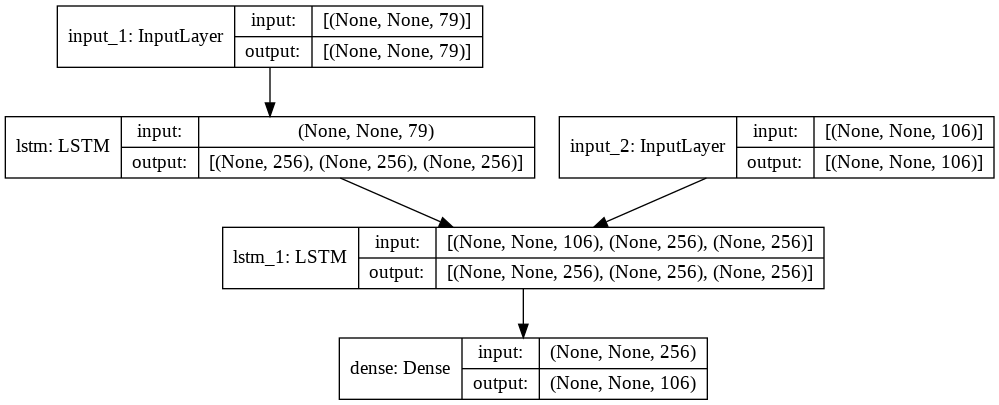

In [22]:
plot_model(model, show_shapes = True)

In [23]:
model.compile(optimizer = 'rmsprop',
              loss = 'categorical_crossentropy')

디코더는 인코더의 마지막 은닉 상태를 초기 은닉 상태로 사용한다. 위에서 initial_state의 인자값으로 encoder_states를 주는 코드가 이에 해당된다. 또한 동일하게 디코더의 은닉 상태 또한 256으로 주었다. 디코더도 은닉 상태, 셀 상태를 리턴하기는 하지만 훈련 과정에서는 사용하지 않는다. 그 후 출력층에 프랑스어 단어 집합의 크기만큼 뉴런을 배치한 후 소프트맥스 함수를 사용하여 실제값과의 오차를 구한다.


In [24]:
model.fit([encoder_input, decoder_input], y = decoder_target,
          batch_size = 64,
          epochs = 50,
          validation_split = 0.2)


Epoch 1/50
750/750 [==============================] - 21s 17ms/step - loss: 1.0438 - val_loss: 0.6942
Epoch 2/50
750/750 [==============================] - 12s 16ms/step - loss: 0.5064 - val_loss: 0.5587
Epoch 3/50
750/750 [==============================] - 12s 16ms/step - loss: 0.4119 - val_loss: 0.4938
Epoch 4/50
750/750 [==============================] - 12s 16ms/step - loss: 0.3626 - val_loss: 0.4580
Epoch 5/50
750/750 [==============================] - 12s 16ms/step - loss: 0.3305 - val_loss: 0.4334
Epoch 6/50
750/750 [==============================] - 12s 16ms/step - loss: 0.3087 - val_loss: 0.4146
Epoch 7/50
750/750 [==============================] - 12s 16ms/step - loss: 0.2912 - val_loss: 0.4013
Epoch 8/50
750/750 [==============================] - 12s 16ms/step - loss: 0.2761 - val_loss: 0.3921
Epoch 9/50
750/750 [==============================] - 12s 16ms/step - loss: 0.2637 - val_loss: 0.3854
Epoch 10/50
750/750 [==============================] - 12s 16ms/step - loss: 0.254

입력으로는 인코더 입력과 디코더 입력이 들어가고, 디코더의 실제값인 decoder_target도 필요하다. 배치 크기는 64로 하였으며 총 50 에포크를 학습한다. 위에서 설정한 은닉 상태의 크기와 에포크 수는 실제로는 훈련 데이터에 과적합 상태를 불러온다. 중간부터 검증 데이터에 대한 오차인 val_loss의 값이 올라가는데, 사실 이번 실습에서는 주어진 데이터의 양과 태스크의 특성으로 인해 훈련 과정에서 훈련 데이터의 정확도와 과적합 방지라는 두 마리 토끼를 동시에 잡기에는 쉽지 않다. 여기서는 우선 seq2seq의 메커니즘과 짧은 문장과 긴 문장에 대한 성능 차이에 대한 확인을 중점으로 두고 훈련 데이터에 과적합 된 상태로 동작 단계로 넘어간다.


#### 4) seq2seq 기계 번역기 동작시키기

앞서 seq2seq는 훈련할 때와 동작할 때의 방식이 다르다고 언급한 바 있다. 이번에는 입력한 문장에 대해서 기계 번역을 하도록 모델을 조정하고 동작시켜보도록 하겠다.

전체적인 번역 동작 단계를 정리하면 아래와 같다.

1. 번역하고자 하는 입력 문장이 인코더에 들어가서 은닉 상태와 셀 상태를 얻는다.
2. 상태와 <(SOS)>에 해당하는 '\t'를 디코더로 보낸다.
3. 디코더가 <(EOS)>에 해당하는 '\n'이 나올 때까지 다음 문자를 예측하는 행동을 반복한다. 


In [25]:
encoder_model = Model(inputs = encoder_inputs, outputs = encoder_states)

우선 인코더를 정의한다. encoder_inputs와 encoder_states는 훈련 과정에서 이미 정의한 것들을 재사용하는 것이다. 이제 디코더를 설계해보겠다.


In [26]:
# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape = (256, ))
decoder_state_input_c = Input(shape = (256, ))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs, initial_state = decoder_states_inputs)
# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용.
# 이는 뒤의 함수 decode_sequence()에 구현
decoder_states = [state_h, state_c]
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs = decoder_softmax_layer(decoder_outputs)
decoder_model = Model(inputs = [decoder_inputs] + decoder_states_inputs,
                      outputs = [decoder_outputs] + decoder_states)

In [27]:
index_to_src = dict((i, char) for char, i in src_to_index.items())
index_to_tar = dict((i, char) for char, i in tar_to_index.items())

단어로부터 인덱스를 얻는 것이 아니라 인덱스로부터 단어를 얻을 수 있는 index_to_src와 index_to_tar를 만들었다.


In [28]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    states_value = encoder_model.predict(input_seq)

    # <SOS>에 해당하는 원-핫 벡터 생성
    target_seq = np.zeros((1, 1, tar_vocab_size))
    target_seq[0, 0, tar_to_index['\t']] = 1.

    stop_condition = False
    decoded_sentence = ""

    # stop_condition이 True가 될 때까지 루프 반복
    while not stop_condition:
        # 이전 시점의 상태 states_value를 현 시점의 초기 상태로 사용
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        # 예측 결과를 문자로 변환
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = index_to_tar[sampled_token_index]

        # 현재 시점의 예측 문자를 예측 문장에 추가
        decoded_sentence += sampled_char

        # <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_char == '\n' or len(decoded_sentence) > max_tar_len):
            stop_condition = True
        
        # 현재 시점의 예측 결과를 다음 시점의 입력으로 사용하기 위해 저장
        target_seq = np.zeros((1, 1, tar_vocab_size))
        target_seq[0, 0, sampled_token_index] = 1.

        # 현재 시점의 상태를 다음 시점의 상태로 사용하기 위해 저장
        states_value = [h, c]

    return decoded_sentence

In [29]:
for seq_index in [3, 50, 100, 300, 1001]: # 입력 문장의 인덱스
    input_seq = encoder_input[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print(35 * '-')
    print('입력 문장:', lines.src[seq_index])
    print('정답 문장:', lines.tar[seq_index][1:len(lines.tar[seq_index]) - 1]) # '\t'와 '\n'을 빼고 출력
    print('번역기가 번역한 문장:', decoded_sentence[:len(decoded_sentence) - 1]) # '\n'을 빼고 출력
    

-----------------------------------
입력 문장: Run!
정답 문장: Cours !
번역기가 번역한 문장: Cours !
-----------------------------------
입력 문장: I left.
정답 문장: Je suis parti.
번역기가 번역한 문장: Je suis parti.
-----------------------------------
입력 문장: Burn it.
정답 문장: Brûlez-la.
번역기가 번역한 문장: Brûlez-la.
-----------------------------------
입력 문장: Drive on.
정답 문장: Continue à rouler !
번역기가 번역한 문장: Avancez !
-----------------------------------
입력 문장: Step back.
정답 문장: Recule !
번역기가 번역한 문장: Reculez !


지금까지 글자 단위의 seq2seq를 구현하였다. 이전 모델들에 비해서 난이도가 확 높아져서 어려웠을 수 있었는데, 고생했다. 다음 챕터에서는 이번 챕터에서 배운 내용을 바탕으로 글자 단위에서 단어 단위로 확장해서 기계 번역기를 구현해보겠다.


https://papers.nips.cc/paper/5346-sequence-to-sequence-learning-with-neural-networks.pdf

https://chunml.github.io/ChunML.github.io/project/Sequence-To-Sequence/

https://hackernoon.com/text-summarization-using-keras-models-366b002408d9

